In [1]:
from normal_form_flint import *
import gc # Invoke garbage collector to offload excess RAM usage: gc.collect()

## Transformation of the Hamiltonian

The Hamiltonian is scaled and recentered about the $L_1$ equilibrium point. A Taylor expansion up to order N is obtained using the `H_n()` function with the default option of `stage=recenter`.

In [2]:
H11r = H_n(11, stage='recenter')

Next, a real diagonal symplectic change of variables is implemented to put the 2nd order terms of the Hamiltonian into a diagonal (i.e. modal) form. This is accomplished using the matrix `D` from the output of `diag_linear()`. The other outputs of that function are the corresponding 2nd order modes of the $L_1$ equilibrium point: $\lambda, \omega_1, \omega_2$, corresponding to the in-plane saddle mode, in-plane center mode, and out-of-plane center mode, respectively. For convenience, this transform is implemented by specifying the flag `stage=diagonalize` within the function `H_n()` as follows: 

In [3]:
H11d = H_n(11, stage='diagonalize')

At this point, it is prudent to apply a transformation which complexifies the terms in the Hamiltonian. This has the desirable effect of making the homological equation trivial to solve in a future step. This is accomplished by applying the transformation defined by the matrix `C` from the output of `cmplx_xfrm()`. For convenience, this is implemented by specifying the flag `stage=complexify` in the call to `H_n()`.  

In [4]:
H11 = H_n(11, stage='complexify')

## A short interlude on `Poly` objects
This code implements the `Poly` class to represent polynomials and perform polynomial operations (e.g. addition, multiplication, differentiation) using as a backend the `python-flint` module (a wrapper of the powerful FLINT C routines for polynomial manipulation). 

Let us take a look at the polynomial representing the 12th-order expansion of the complexified Hamiltonian. There are thousands of terms inside. 

In [5]:
H11bd = H11.by_degree()  # Returns a dict ~ {degree [int]: polynomial [Poly], ...}

In [7]:
for deg in H11bd.keys():
    print('degree: ', deg, ', # terms: ', len(H11bd[deg].poly.monoms()))

degree:  2 , # terms:  3
degree:  3 , # terms:  52
degree:  4 , # terms:  142
degree:  5 , # terms:  308
degree:  6 , # terms:  650
degree:  7 , # terms:  1212
degree:  8 , # terms:  2199
degree:  9 , # terms:  3696
degree:  10 , # terms:  6069
degree:  11 , # terms:  9464


Let's look at just one of these monomial terms, for example, the term $cq_1q_2^{2}p_1^4p_2^5$. This is alternately represented by multi-index notation as $h_{\mathbf{k}_q, \mathbf{k}_p}\mathbf{q}^{\mathbf{k}_q}\mathbf{p}^{\mathbf{k}_p}$ where the multi-indices $\mathbf{k}_q, \mathbf{k}_p$ in this case are $(1,2,0), (4,5,0)$, respectively. To query the coefficient, we concatenate the multi-indices and the variable representing the imaginary number $j$ in the order `(j, kq1, kq2, kq3, kp1, kp2, kp3)`. This is passed as an index to the `Poly.poly` attribute of our Hamiltonian, which is a `Poly` object. By choosing `j=0,2,4,...`, we recover elements of the real part of the coefficient, whereas the imaginary parts are scattered amongst `j=1,3,5,...` The coefficients are `fmpq` objects, which is the FLINT representation of a rational number; these can be evaluated into Python `float`s using the `q2float()`, which casts the numerator and the denominator as very large `int`s before dividing them. Ideally, this is performed at the last possible opportunity to maintain numerical precision throughout intermediate polynomial operations, and especially when there is multiplication by factors of the form $\frac{1}{n!}$ at high orders. 

In [10]:
print('As fmpq rational number objects:')
print(H11bd[11].poly[(1,0,2,0,5,4,0)]) # Part of the real component; others at j=2,4,...
# Numerator and denominator are 226-digit integers!

print('\nAs 64-bit floats:')
print('%0.65f'%q2float(H11bd[11].poly[(1,0,2,0,5,4,0)])) # Notice that precision is lost here

As fmpq rational number objects:
-7468019841741367107101163293936531198070347167292882423546241565217080340137362188020281291357764671540169634900331257207812047555276933685145180846619121321982883119408850742381728341958678095169831148695858125/42081087212386988057927919063041029324402718422585390875986247224549857234376646576909332290220707609815863750849425741704155458001470430905022518165215046799641789369027556785533310063074581738170346013886251008

As 64-bit floats:
-0.17746736922574282702136372336099157109856605529785156250000000000


Not very efficient, right? There are more terms than needed! Unfortunately, the FLINT routines do not support complex coefficients, so we are using the next best thing: rational coefficients. We could have alternately used `SymPy`, which does support multivariate polynomials with complex coefficients; however, we are achieving several orders of magnitude faster operations with the FLINT routines with only a multiplicative increase in memory cost on the order of $N$.

The higher-order monomials in the variable `j` can be collapsed using the `Poly.simplify()` method, which can take a non-negligible amount of time for higher-order polynomials. Furthermore, the `j` variable can be subsumed into the coefficients represented as Python `complex` numbers by using the `Poly.as_dict()` method. This further removes terms, at the expense of being able to perform high-precision polynomial operations. You can freely move between this `dict` represenation and the `Poly` object with the aforementioned method and vice versa by simply calling `Poly(d)` on any dictionary representation `d`, which simply reconstructs the FLINT polynomial with redundant `j` variable and rational coefficients. 

In [11]:
print('Before simplification:')
for deg in H11bd.keys():
    print('degree: ', deg, ', # terms: ', len(H11bd[deg].simplify().poly.monoms()))
print('\ndict representation (rationals reduced to complex coefficients):')
for deg in H11bd.keys():
    print('degree: ', deg, ', # terms: ', len(H11bd[deg].as_dict()))

Simplification:
degree:  2 , # terms:  3
degree:  3 , # terms:  40
degree:  4 , # terms:  102
degree:  5 , # terms:  192
degree:  6 , # terms:  382
degree:  7 , # terms:  634
degree:  8 , # terms:  1089
degree:  9 , # terms:  1664
degree:  10 , # terms:  2593
degree:  11 , # terms:  3736

dict representation (rationals reduced to complex coefficients):
degree:  2 , # terms:  3
degree:  3 , # terms:  32
degree:  4 , # terms:  70
degree:  5 , # terms:  136
degree:  6 , # terms:  246
degree:  7 , # terms:  416
degree:  8 , # terms:  671
degree:  9 , # terms:  1036
degree:  10 , # terms:  1547
degree:  11 , # terms:  2240


How fast is FLINT at performing polynomial operations? Just for fun, let's monitor how long it takes to multiply together the 6th-degree terms of the Hamiltonian with the 7th-degree terms, resulting in a 13-th order polynomial (This would be a very lengthy process in pure Python!)

In [13]:
%timeit H11bd[6] * H11bd[7]

77.6 ms ± 3.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


At this point, we have the Hamiltonian recentered at the $L_1$ point and have coerced it into a complex, diagonal form, such that the modes of the linearized dynamics (i.e., the modes of $H_2$) are decoupled. However, we need to put this Hamiltonian into its normal form by applying a Lie series transformation with a generating function $G$. While this generating function (a.k.a. generator) is not yet known, we know the structural form that $\bar{H}$ must take: it must have decouple-able modes, i.e., all terms must commute with the already-decoupled $H_2$ term. 

Thus, we can compute $G_3$ by solving the homological equation with $H_2$ and the third-order terms of our current Hamiltonian:

$\{H_2, G_3\} + H_3^{(2)} = 0$, which generalizes to:

$\{H_2, G_k\} + H_k^{(k-1)} = 0$

Where $\{H_2, G_k\}$ denotes the Poisson bracket of $H_2$ with $G_k$, equivalently the Lie derivative of $H_2$, which we denote with the operator $L_{G_k}(H_2)$. The superscript $(2)$ denotes the normal-form order of the Hamiltonian (i.e., the maximum degree to which monomials have been transformed into their normal form, noting that the 2nd-order terms are effectively in this form at this point such that $H^{(2)}$ is the result of the transformations made thus far), and the subscript $3$ denotes the part of the Hamiltonian consisting only of monomials of that degree.  

The effort of complexifying pays off presently when solving for $G_k$, since the Lie derivative simplifies to scalar multiplication under this construction. If $\nu \triangleq [\lambda, j\omega_1, j\omega_2]$, then we solve for $G_k$ as follows:

\begin{equation}
g_{\mathbf{k}_q, \mathbf{k}_p}\mathbf{q}^{\mathbf{k}_q}\mathbf{p}^{\mathbf{k}_p} = \sum_{\lvert\mathbf{k}_q\rvert + \lvert\mathbf{k}_p \rvert = k} \frac{-h_{\mathbf{k_q}, \mathbf{k}_p}}{\nu \cdot (\mathbf{k}_p - \mathbf{k}_q)}
\end{equation}

The function `generator(H_prev, k)` implements this simple inversion and outputs a `Poly` object:

## Obtaining the Generating Functions

In [7]:
G3 = generator(H11bd, 3)

For odd degrees $k=3,5,7,...$, the generator $G_k$ will eliminate all monomials of the same degree from the Hamiltonian once the Lie transformation is applied. However, for even degrees $k=4, 6, 8, ...$, the Lie derivative operator has a non-trivial null space: $\nu \cdot (\mathbf{k}_p-\mathbf{k}_q) $ can take on a zero value, causing the inversion of the homological equation to be undefined. Thus, we add the following caveat to the summation index: $\lvert\mathbf{k}_q\rvert \neq \lvert\mathbf{k}_p\rvert$ The result of this fact is that $G_k$ cannot eliminate monomials of the form $h_{\mathbf{k},\mathbf{k}}\mathbf{q}^\mathbf{k}\mathbf{p}^\mathbf{k}$, which we refer to as 'resonant' monomials since they commute with $H_2$. Thus, after the Lie series transformation, the normal-form Hamiltonian organized by degree looks like:

$\bar{H} = H_2 + \bar{H}_4 + \bar{H}_6 + ...$

The Lie series transformation is a recursive operation:

\begin{split}
H^{(k)} &= H^{(k-1)} + \{H^{(k-1)}, G_k\} + \frac{1}{2!}\{\{H^{(k-1)}, G_k\}, G_k\}~+~ ...\\
        &= H^{(k-1)} + L_{G_k}H^{(k-1)} + \frac{1}{2!}L_{G_k}^2H^{(k-1)} + \frac{1}{3!}L_{G_k}^3H^{(k-1)}~+~...\\
        &= \text{exp}(L_{G_k})H^{(k-1)} 
\end{split}
        
Where we borrow (conceptually) from the form of the Taylor series expansion of the exponential function to compactly represent (notationally) the infinite-series nature of the operation. 

It is here noteworthy to mention that the output degree of the Poisson bracket $\{H_i, G_k\}$ is $i+k-2$, which leads to the fact that the output of the $n$-fold nested Lie derivative $L_{G_k}^nH_i$ is equal to $i+nk-2n$. The practical implication of this fact is that if a normal form up to truncation order $N$ is desired, not only can the series expansion of $H^{(2)}$ be truncated at $N$, but any Lie derivative within the Lie series transformation that would produce a term possessing a degree of $i+nk-2n > N$ may also be skipped as those higher-order terms never influence the construction of generators up to $G_N$. 

This is implemented as `expLg(H_prev, G_k, k, N)` where $k$ is the degree of $G_k$ and $N$ is the desired truncation order, which indicates which Lie derivatives can be skipped. This is a good opportunity to test for the expected result, which is that $H^{(3)}$ should not have any monomials of order $3$:

In [8]:
t1 = time()
H3bd = expLg(H11bd, G3, 3, 11)
print('This Lie series transformation took %0.2f seconds.'%(time()-t1))

This Lie series transformation took 5.00 seconds.


In [17]:
print('Simplifying...')
H3bd = Poly(H3bd).simplify().by_degree()  # Clean up terms with zero coeffs, check for real/imag cancellations, etc.
for deg in H3bd.keys():
    print('Degree: %i, # terms: %i'%(deg, len(H3bd[deg].as_dict())))

print('Note lack of 3rd-degree terms. These were removed by the normalization process.')

Simplifying...
Degree: 2, # terms: 3
Degree: 4, # terms: 70
Degree: 5, # terms: 136
Degree: 6, # terms: 246
Degree: 7, # terms: 416
Degree: 8, # terms: 671
Degree: 9, # terms: 1036
Degree: 10, # terms: 1547
Degree: 11, # terms: 2240
Note lack of 3rd-degree terms. These were removed by the normalization process.


We should also test that the next generator, $G_4$, behaves as expected by eliminating all non-resonant monomials:

In [18]:
G4 = generator(H3bd, 4)
t1 = time()
H4bd = expLg(H3bd, G4, 4, 11)
print('This Lie series transformation took %0.2f seconds.'%(time()-t1))
print('Note that this transformation should be faster than the first since we\n'+\
      'are one degree closer to the truncation order.')

This Lie series transformation took 0.57 seconds.
Note that this transformation should be faster than the first since we
are one degree closer to the truncation order.


In [19]:
print('Simplifying...')
H4bd = Poly(H4bd).simplify().by_degree() # Clean up terms with zero coeffs, check for real/imag cancellations, etc.
for deg in H4bd.keys():
    print('Degree: %i, # terms: %i'%(deg, len(H4bd[deg].as_dict())))
print('4th-order terms in the current Hamiltonian:')
print('(Note the symmetry in the multi-indices denoting these as resonant monomials)')
H4bd[4].as_dict()

Simplifying...
Degree: 2, # terms: 3
Degree: 4, # terms: 6
Degree: 5, # terms: 136
Degree: 6, # terms: 246
Degree: 7, # terms: 416
Degree: 8, # terms: 671
Degree: 9, # terms: 1036
Degree: 10, # terms: 1547
Degree: 11, # terms: 2240
4th-order terms in the current Hamiltonian:
(Note the symmetry in the multi-indices denoting these as resonant monomials)


{(0, 0, 2, 0, 0, 2): (0.1448825212555807+0j),
 (2, 0, 0, 2, 0, 0): (-0.21937337601705853+0j),
 (0, 2, 0, 0, 2, 0): (0.16210137757583+0j),
 (1, 1, 0, 1, 1, 0): -0.7537617318128039j,
 (1, 0, 1, 1, 0, 1): -0.6892623796413667j,
 (0, 1, 1, 0, 1, 1): (0.07261491091311015+0j)}

To obtain the normal form of the Hamiltonian up to some truncation order $N$, the Lie series transformation must be recursively applied in succession for generators $G_3, G_4, G_5, ..., G_N$:

$H^{(N)} = [\text{exp}(L_{G_N})\text{exp}(L_{G_{N-1}})...\text{exp}(L_{G_3})]H^{(2)}$

Note that other methods exist; this one in particular is called the Dragt-Finn method. For a comprehensive discussion of this and others, refer to David Schwab's thesis. 

This recursion is implemented via the function `lieSeriesXfrm(H, N)`, which takes as inputs the initial (complex-diagonal) Hamiltonian (equivalently, $H^{(2)}$ with our notation) and the desired truncation order N and provides as outputs a list of the generators $G_3, G_4, ..., G_N$ and a list of intermediate Hamiltonians $H^{(3)}, H^{(4)}, ..., H^{(N)}$. Notice how the longest step in this process is the first step, with each subsequent step speeding up due to discarding Lie derivatives above order $N$.

Finally, with the generating functions in hand, the utility of the complexification step is expended; retaining the generators in these variables and including it in the sequence of transformations is both redundant and places a heavier-than-needed burden on future polynomial arithmetic. For this reason, we realify the generating functions by applying the reverse change of variables associated with the complexification step, encoded by $C^{-1}$:

In [6]:
t1 = time()
Gs, Hs = lieSeriesXfrm(H11bd, 11)
print('This Lie series transformation took %0.2f seconds.'%(time()-t1))
C = cmplx_xfrm()
print('Realifying generators...')
Gs_real = [G.transform(np.linalg.inv(C)).simplify(real=True) for G in Gs]
print('Done.')

Determining generator of degree 3...
Applying Lie series transformation...
Determining generator of degree 4...
Applying Lie series transformation...
Determining generator of degree 5...
Applying Lie series transformation...
Determining generator of degree 6...
Applying Lie series transformation...
Determining generator of degree 7...
Applying Lie series transformation...
Determining generator of degree 8...
Applying Lie series transformation...
Determining generator of degree 9...
Applying Lie series transformation...
Determining generator of degree 10...
Applying Lie series transformation...
Determining generator of degree 11...
Applying Lie series transformation...
This Lie series transformation took 6.86 seconds.
Realifying generators...
Done.


The Lie series transformation acts equivalently on the Hamiltonian and its canonical quantities. Thus, the real canonical quantities in their order-$N$ normal form $\bar{\mathbf{z}}\triangleq(\bar{\mathbf{q}}, \bar{\mathbf{p}})$ are obtained as the result of the following analytic transformation on the real-diagonal canonical quantities $\mathbf{z}\triangleq(\mathbf{q}, \mathbf{p})$. In practice, the sequence of Lie transforms is composed in both directions (i.e. $\text{exp}(L_{G_3}), ..., \text{exp}(L_{G_N})$ and $\text{exp}(L_{-G_N}), ..., \text{exp}(L_{-G_3})$) for each variable symbolically as a polynomial, which can then be evaluated at either $\bar{\mathbf{z}}$ or $\mathbf{z}$ (respectively) to effectuate the associated transformation:

$\bar{\mathbf{z}}=\mathcal{T}_{N}\circ \mathbf{z}:\qquad \mathbf{z} = [\text{exp}(L_{G_N})\text{exp}(L_{G_{N-1}})...\text{exp}(L_{G_3})]\bar{\mathbf{z}}$

An alternate definition of the Lie series transformation is as a "flow along the vector field defined by $G$ for $\tau=1$ (unary fictitious time)." Let us use the notation $\Phi_G$ to describe this numerical transformation as a flow. While this may seem abstract and unhelpful for transforming the Hamiltonian, it actually provides us with another convenient tool for performing the Lie series transformation on the canonical quantities: it tells us that the forward transformation is a Taylor approximation to the integration of:

\begin{equation}
\frac{d\mathbf{z}}{d\tau} = \{\mathbf{z}, G\} = \left(\begin{matrix} \frac{\partial G}{\partial \mathbf{p}} \\ -\frac{\partial G}{\partial \mathbf{q}}  \end{matrix}\right)
\end{equation}


We define $G_k=G_3,G_4,...,G_N$, compute their gradients with respect to $\mathbf{z}$, and use each of these to define vector equations of motion which we will proceed to integrate from $\tau=0 \rightarrow -1$. The ubiquity, maturity, and instrumentability of variable-step-size ODE integrators in scientific computing software gives us fine grained control of this numerical transformation. Conveniently, the sequential flow defined by $G_k$ is reversible, such that the inverse transform can be computed using the flow along the reversed sequence of $G_k$ from $\tau=0\rightarrow1$. 

The transformation is implemented with the `normal_xform` function, which takes as inputs the real-diagonal canonical quantities $\mathbf{z}$, either the list of gradients of $G_k$ or the appropriate analytic transformation polynomial (which will determine whether the numerical or analytical transformation is used), and the direction of the transformation as indicated by the `reverse` flag. 

Pre-computing gradients for the numerical transformations:

In [7]:
# Compose the full polynomial version of G
G = Gs_real[0]
for Gk in Gs_real[1:]:
    G += Gk

# Pre-compute the gradients of G by homogenous part
dGkdZ = [[Gk.deriv(i) for i in range(6)] for Gk in Gs_real]

Pre-computing polynomials for the analytic transformations:

In [8]:
# Don't be confused by notation: we compose the forward sequence of expLg() to obtain 
# The backward transformation (i.e. AA -> Cartesian)
Pqp_bwd = expLg_qp(Gs_real, 11)

Developing backward transformation in variable 1...
Developing backward transformation in variable 2...
Developing backward transformation in variable 3...
Developing backward transformation in variable 4...
Developing backward transformation in variable 5...
Developing backward transformation in variable 6...


In [9]:
# Don't be confused by notation: we compose the backward sequence of expLg() to obtain 
# The forward transformation (i.e. Cartesian -> AA)
Pqp_fwd = expLg_qp(Gs_real, 11, reverse=True)

Developing forward transformation in variable 1...
Developing forward transformation in variable 2...
Developing forward transformation in variable 3...
Developing forward transformation in variable 4...
Developing forward transformation in variable 5...
Developing forward transformation in variable 6...


Let's run a test. Do the numerical and analytic transformations to normal-form canonical variables match?

In [10]:
# Choose an arbitrary point in the vicinity of L1. 
xL1 = (1-mu_EM)-gamma_1
X = np.array([xL1+0.01, 0.01, 0.01, 0.01, 0.01, 0.01]) 

# The sequence of transformations so far are broken out functionally below
Z_canon = cart2canon(X)
Z_scale = scale_recenter(Z_canon, gamma_1)
Z_diag = diagonalize(Z_scale) 
Z1 = normal_xform(Z_diag, dGkdZ)
Z2 = normal_xform(Z_diag, Pqp_fwd)

Z1, Z2

Flowing coordinates along transformation for fictitious time tau = -1...
Done.


(array([ 0.11702394, -0.09747969,  0.10297802, -0.101199  , -0.10777484,
         0.04491517]),
 array([ 0.11702394, -0.0974797 ,  0.10297801, -0.101199  , -0.10777484,
         0.04491517]))

To avoid generating them again, now is a good time to save the pieces of data that allow us to implement the transformations both numerically and analytically, namely, the homogeneous generator gradients `dGkdZ` and the polynomials `Pqp_fwd, Pqp_bwd` encoding the analytic Lie series transformations, respectively. 

In [41]:
save_grad(dGkdZ, 11, overwrite=True)
# dGkdZ = load_grad(12)

Successfully wrote gen to cache/generators/numerical/dGkdZ_11_3_0.pkl
Successfully wrote gen to cache/generators/numerical/dGkdZ_11_3_1.pkl
Successfully wrote gen to cache/generators/numerical/dGkdZ_11_3_2.pkl
Successfully wrote gen to cache/generators/numerical/dGkdZ_11_3_3.pkl
Successfully wrote gen to cache/generators/numerical/dGkdZ_11_3_4.pkl
Successfully wrote gen to cache/generators/numerical/dGkdZ_11_3_5.pkl
Successfully wrote gen to cache/generators/numerical/dGkdZ_11_4_0.pkl
Successfully wrote gen to cache/generators/numerical/dGkdZ_11_4_1.pkl
Successfully wrote gen to cache/generators/numerical/dGkdZ_11_4_2.pkl
Successfully wrote gen to cache/generators/numerical/dGkdZ_11_4_3.pkl
Successfully wrote gen to cache/generators/numerical/dGkdZ_11_4_4.pkl
Successfully wrote gen to cache/generators/numerical/dGkdZ_11_4_5.pkl
Successfully wrote gen to cache/generators/numerical/dGkdZ_11_5_0.pkl
Successfully wrote gen to cache/generators/numerical/dGkdZ_11_5_1.pkl
Successfully wrote g

In [42]:
save_Pqp(Pqp_fwd, 'fwd', 11, overwrite=True)
save_Pqp(Pqp_bwd, 'bwd', 11, overwrite=True)
# Pqp_fwd = load_Pqp('fwd', 12)
# Pqp_bwd = load_Pqp('bwd', 12)

Successfully wrote gen to cache/generators/analytic/Pqp_fwd_11_0.pkl
Successfully wrote gen to cache/generators/analytic/Pqp_fwd_11_1.pkl
Successfully wrote gen to cache/generators/analytic/Pqp_fwd_11_2.pkl
Successfully wrote gen to cache/generators/analytic/Pqp_fwd_11_3.pkl
Successfully wrote gen to cache/generators/analytic/Pqp_fwd_11_4.pkl
Successfully wrote gen to cache/generators/analytic/Pqp_fwd_11_5.pkl
Successfully wrote gen to cache/generators/analytic/Pqp_bwd_11_0.pkl
Successfully wrote gen to cache/generators/analytic/Pqp_bwd_11_1.pkl
Successfully wrote gen to cache/generators/analytic/Pqp_bwd_11_2.pkl
Successfully wrote gen to cache/generators/analytic/Pqp_bwd_11_3.pkl
Successfully wrote gen to cache/generators/analytic/Pqp_bwd_11_4.pkl
Successfully wrote gen to cache/generators/analytic/Pqp_bwd_11_5.pkl


The final step is to generate the action-angle coordinates from the real normal-form canonical quantities. Since we are dealing with $L_1$, the first action is a saddle action, while the other two are center actions. The angles are also computed differently between stability types; saddles use a hyperbolic angle while centers use an elliptical form. 

\begin{equation}
I_u \triangleq q_u p_u, \qquad \theta_u \triangleq \ln{\frac{\sqrt{q_u}}{\sqrt{p_u}}} 
\end{equation}

With $u$ standing for unstable (saddle) indices, and 

\begin{equation}
I_s \triangleq \frac{1}{2}(q^2_s + p^2_s), \qquad \tan{\theta_s} \triangleq \frac{p_s}{q_s} 
\end{equation}

With $s$ standing for stable (center) indices; of course, in the case of $L_1$, $u=1$ and $s=(2,3)$. Let's denote the final vector representation of action-angle coordinates as $\Theta \triangleq (I_1, I_2, I_3, \theta_1, \theta_2, \theta_3)$.


We can write out the transformation of a general set of Cartesian coordinates $\mathbf{x}$ in the Earth-Moon synodic frame to the complex normal-form canonical quantities as a composition of transformations:

$\Theta = \mathcal{T}_\text{AA} \circ \Phi_{G} \circ \mathcal{T}_\text{diag} \circ \mathcal{T}_\text{canon} \circ \mathcal{T}_\text{scale} \circ \mathcal{T}_\text{recenter} \circ \mathbf{x}$

The inverse transformation simply involves the reverse composition of inverted intermediate transformations.

This is implemented as `cart2aa(X, G, dGdX=None, reverse=False)`. The input is any set of coordinates $\mathbf{x}$ from the Cartesian synodic phase space, the composed generating function $G$, and optionally the gradient (to skip computations) and a flag to reverse the transformation. Let us illustrate this process for a general point nearby the $L_1$ location. 


It is useful to note 3 things about these action-angle coordinates. 

* First, while they are not true integrals of motion due to the finite-order truncation of the Hamiltonian, they serve as a "higher-order-fit" analog to modes of the linearized dynamics; that is, we could say that a state possessing $I_1=0$ lies within the center subspace of the approximate $L_1$ dynamics up to our truncation order (which corresponds to some region of validity). This is much more powerful and predictive than the subspaces of the linearized dynamics. 

* Second, notice the imaginary part of $\theta_1$, which encodes information about the quadrant of the hyperbolic angle's span, which in turn corresponds to the type of saddle motion (reflect on either side, transit from/to either side).

* Third, the numerical and analytical methods of transformation can produce differing results. In general, the numerical flow method is more accurate within the region of validity due to the propagation of truncation error inherent in the analytical method. For more details on this, see [Schwab], [Hunsberger]. 

To test our implementation, we will select an arbitrary set of action-angle coordinates lying in the planar center subspace of $L_1$ and plot the corresponding Cartesian trajectory as we vary $\theta_2$ from $0\rightarrow2\pi$. 

In [11]:
# Compare the results of numerical method and the analytical method 
print(cart2AA(X, dGkdZ))
print(cart2AA(X, Pqp_fwd))

Flowing coordinates along transformation for fictitious time tau = -1...
Done.
[0.01184271+0.j         0.01055885+0.j         0.00631092+0.j
 0.07264485-1.57079633j 2.30607855+0.j         5.87189786+0.j        ]
[0.01184271+0.j         0.01055885+0.j         0.00631092+0.j
 0.07264485-1.57079633j 2.30607857+0.j         5.87189787+0.j        ]


In [12]:
# Now, compare the results of the AA -> Cartesian transform
# Choose a Lyapunov orbit with I2 = 0.3
AA0 = [0,0.3,0,0,0,0]

x1 = cart2AA(AA0, dGkdZ, reverse=True)
x2 = cart2AA(AA0, Pqp_bwd, reverse=True)

print(x1)
print(x2)

[ 0.84886449 -0.08489491  0.         -0.05812113  0.00645526  0.        ]
[ 0.84886453 -0.08489492  0.         -0.05812114  0.00645544  0.        ]


In [19]:
def CR3BP(t, state):
    mu=mu_EM
    x, y, z, xdot, ydot, zdot = state

    r1 = np.sqrt((x + mu)**2 + y**2 + z**2)
    r2 = np.sqrt((x - (1 - mu))**2 + y**2 + z**2)

    xdd = 2 * ydot + x - (1 - mu) * (x + mu) / r1**3 - mu * (x - (1 - mu)) / r2**3
    ydd = -2 * xdot + y - (1 - mu) * y / r1**3 - mu * y / r2**3
    zdd = -(1 - mu) * z / r1**3 - mu * z / r2**3

    return np.array([xdot, ydot, zdot, xdd, ydd, zdd])


def RTBprop(tspan, state,options={'rtol':1e-12, 'atol':1e-12}):
    return solve_ivp(CR3BP,(tspan[0],tspan[-1]),state,t_eval=tspan,**options).y


import matplotlib.pyplot as plt

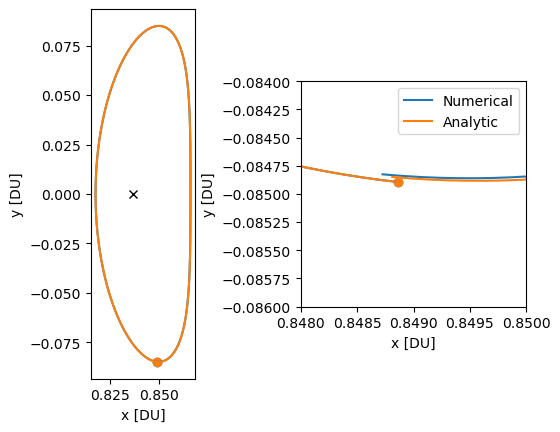

In [13]:
x1s = RTBprop(np.linspace(0,2.81,1000), x1)
x2s = RTBprop(np.linspace(0,2.81,1000), x2)

fig, axs = plt.subplots(1,2)
for ax in axs:
    ax.plot(x1s[0], x1s[1], label='Numerical')
    ax.plot(x2s[0], x2s[1], label='Analytic')
    ax.scatter(x1s[0,0], x1s[1,0])
    ax.scatter(x2s[0,0], x2s[1,0])
    ax.plot(xL1, 0, c='k', marker='x')
    ax.set_aspect('equal')
    ax.set_xlabel('x [DU]')
    ax.set_ylabel('y [DU]')
axs[1].set_xlim([0.848, 0.850])
axs[1].set_ylim([-0.086,-0.084])
axs[1].legend()


In [14]:
%timeit cart2AA(AA0, Pqp_bwd) # Polynomial evaluations are pretty fast.
# To do: See if this can be faster if we create a RealPoly class that has only 6 variables instead of 7. 

3.2 ms ± 83.1 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Text(0.835, -0.02, 'L1')

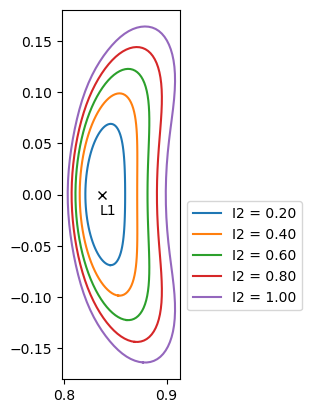

In [15]:
# Look at a range of actions
xL1 = (1-mu_EM)-gamma_1
fig, ax = plt.subplots()
ax.set_aspect('equal')
for i2 in np.linspace(0.2, 1, 5):
    Xs = []
    for th in np.linspace(0,2*np.pi,100):
        AA = (0, i2, 0, 0, th, 0)
        Xs.append(cart2AA(AA, Pqp_bwd, reverse=True)) # Why backwards??
        # Xs.append(cart2aa(AA, dGkdZ, method='flow', reverse=True))
    ax.plot([x[0] for x in Xs], [x[1] for x in Xs], label='I2 = %0.2f'%i2)
ax.plot(xL1,0,color='k',marker='x')
ax.legend(bbox_to_anchor=(1,0.5))
ax.text(0.835, -0.02, 'L1')

### Hamiltonian analysis

In [86]:
H = Poly(Hs[-1]).transform(np.linalg.inv(C)).simplify(real=True)
# save(H, 'H11', 'ham')

Successfully wrote ham to cache/hamiltonians/H11.pkl


In [84]:
n = 100
I2 = np.linspace(0, 1, n)
I3 = np.linspace(0, 1, n)
I2_, I3_ = np.meshgrid(I2, I3)
Hi = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        i2, i3 = I2[i], I3[j]
        qp = canon2AA((0,i2,i3,0,0,0), reverse=True)
        Hi[j,i] = np.real(H.eval(qp))

Text(0.5, 1.0, 'Hamiltonian, N=11')

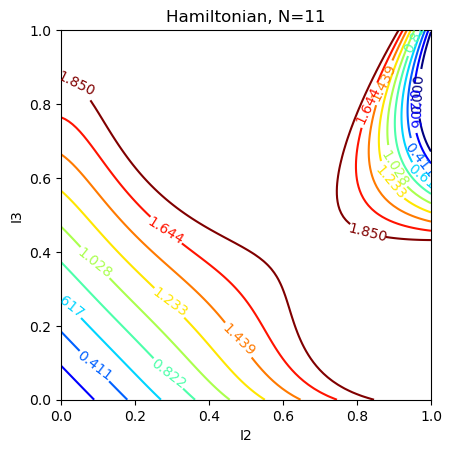

In [85]:
fig, ax = plt.subplots()
CS = ax.contour(I2, I3, Hi, levels=np.linspace(0,1.8500,10), cmap='jet')
ax.clabel(CS)
ax.set_aspect('equal')
ax.set_xlabel('I2')
ax.set_ylabel('I3')
ax.set_title('Hamiltonian, N=11')

In [87]:
t1 = time()
H22bd = H_n(22, stage='complexify').by_degree()
Gs, Hs = lieSeriesXfrm(H22bd, 22)
print('This Lie series transformation took %0.2f seconds.'%(time()-t1))
C = cmplx_xfrm()
print('Realifying generators...')
Gs_real = [G.transform(np.linalg.inv(C)).simplify(real=True) for G in Gs]
print('Done.')

Determining generator of degree 3...
Applying Lie series transformation...
Determining generator of degree 4...
Applying Lie series transformation...
Determining generator of degree 5...
Applying Lie series transformation...
Determining generator of degree 6...
Applying Lie series transformation...
Determining generator of degree 7...
Applying Lie series transformation...
Determining generator of degree 8...
Applying Lie series transformation...
Determining generator of degree 9...
Applying Lie series transformation...
Determining generator of degree 10...
Applying Lie series transformation...
Determining generator of degree 11...
Applying Lie series transformation...
Determining generator of degree 12...
Applying Lie series transformation...
Determining generator of degree 13...
Applying Lie series transformation...
Determining generator of degree 14...
Applying Lie series transformation...
Determining generator of degree 15...
Applying Lie series transformation...
Determining generat

In [88]:
H = Poly(Hs[-1]).transform(np.linalg.inv(C)).simplify(real=True)

In [89]:
save(H, 'H22', 'ham')

Successfully wrote ham to cache/hamiltonians/H22.pkl


In [93]:
n = 100
I2 = np.linspace(0, 1, n)
I3 = np.linspace(0, 1, n)
I2_, I3_ = np.meshgrid(I2, I3)
Hi = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        i2, i3 = I2[i], I3[j]
        qp = canon2AA((0,i2,i3,0,0,0), reverse=True)
        Hi[j,i] = np.real(H.eval(qp))

Text(0.5, 1.0, 'Hamiltonian, N=22')

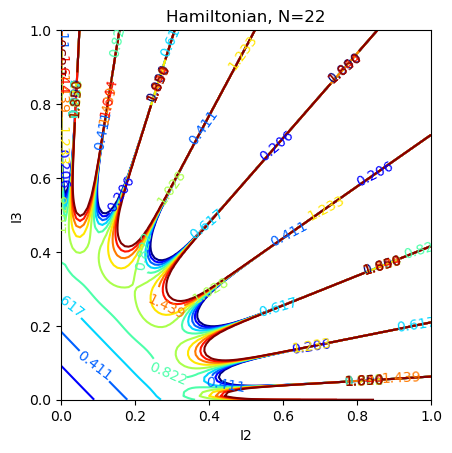

In [95]:
fig, ax = plt.subplots()
CS = ax.contour(I2, I3, Hi, levels=np.linspace(0,1.8500,10), cmap='jet')
ax.clabel(CS)
ax.set_aspect('equal')
ax.set_xlabel('I2')
ax.set_ylabel('I3')
ax.set_title('Hamiltonian, N=22')

In [97]:
# Compose the full polynomial version of G
G = Gs_real[0]
for Gk in Gs_real[1:]:
    G += Gk

# Pre-compute the gradients of G by homogenous part
dGkdZ = [[Gk.deriv(i) for i in range(6)] for Gk in Gs_real]

Pre-computing polynomials for the analytic transformations:

In [ ]:
# Don't be confused by notation: we compose the forward sequence of expLg() to obtain 
# The backward transformation (i.e. AA -> Cartesian)
Pqp_bwd = expLg_qp(Gs_real, 22)

Developing backward transformation in variable 1...
Developing backward transformation in variable 2...
Developing backward transformation in variable 3...


In [12]:
# Don't be confused by notation: we compose the backward sequence of expLg() to obtain 
# The forward transformation (i.e. Cartesian -> AA)
Pqp_fwd = expLg_qp(Gs_real, 22, reverse=True)

Developing forward transformation in variable 1...
Developing forward transformation in variable 2...
Developing forward transformation in variable 3...
Developing forward transformation in variable 4...
Developing forward transformation in variable 5...
Developing forward transformation in variable 6...
